In [1]:
import torch
from src.utils.build_model import build_model
from src.utils.misc import load_config, interpolate_linear
import numpy as np
import matplotlib.animation as animation
from src.utils.misc import animate_videos
from matplotlib import pyplot as plt
import os

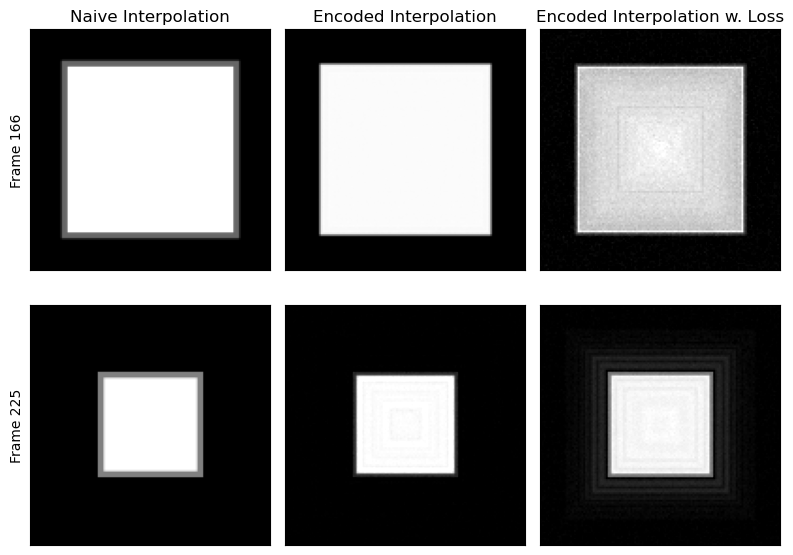

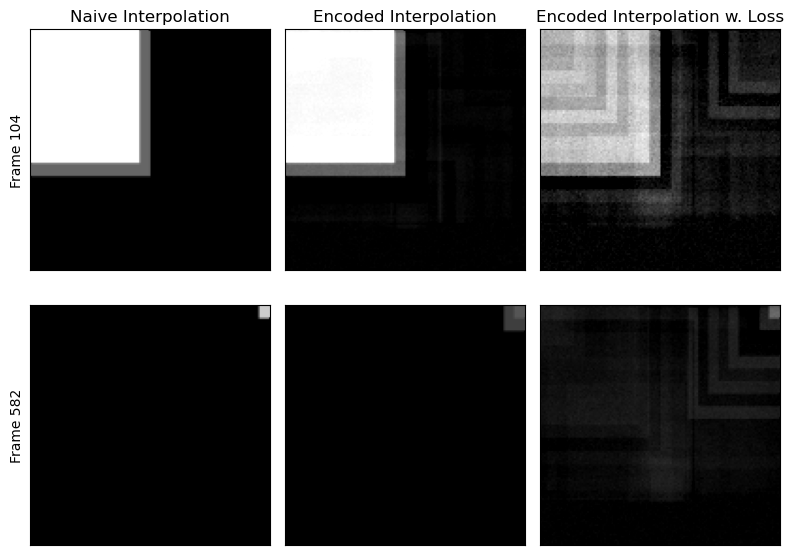

In [3]:
# set animation flag. If true, runtime is much higher due to saving
animate = False


# load videos
size_video = np.load('data/size_video.npy')
moving_video = np.load('data/moving_video.npy')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set model titles for plots
model_titles = ['Naive Interpolation', 'Encoded Interpolation', 'Encoded Interpolation w. Loss']


for video, video_name, frames_of_interest in zip([size_video, moving_video], ['Regular', 'Moving'], [[166, 225], [104, 582]]):

    # Interpolate in pixel space
    interpolated_video = interpolate_linear(np.arange(len(video)), np.arange(0, len(video), 0.1), video)
   
    # Load configuration
    config_path = f'configs/config_{video_name}.yaml'
    CFG = load_config(config_path)

    # convert data for use with model
    video = torch.tensor(video.astype(np.float32))
    
    # Set up the figure
    fig, axs = plt.subplots(len(frames_of_interest), 3, figsize=(8, 6))


    # Plot frames from naive interpolation
    for i, frame in enumerate(frames_of_interest):
        axs[i, 0].imshow(interpolated_video[frame], cmap='gray', vmin=0, vmax=255)
        axs[i, 0].set_ylabel(f'Frame {frame}')


    # Loop over models
    interpolated_videos = [interpolated_video]
    model_names = ['Regular', 'Interp']
    for j, model_name in enumerate(model_names, 1): # Start at 1 to skip the naive interpolation

        # Build the model shell
        model = build_model(CFG, device, loss_type=model_name)
        
        # Load the saved model weights
        model_path = "data/model_weights/"+model_name+"_"+video_name+".pth"
        model.load_state_dict(torch.load(model_path))

        # Set the model to evaluation mode
        model.eval()

        # Interpolate in latent space
        encoded = model.encoder(video).detach().cpu().numpy()
        encoded_interpolated = interpolate_linear(np.arange(len(encoded)), np.arange(0, len(encoded), 0.1), encoded).astype(np.float32)
        output_interpolated = model.decoder(torch.tensor(encoded_interpolated).to(device)).detach().cpu().numpy()

        # Append the interpolated video to the list of videos
        interpolated_videos.append(output_interpolated)

        # Plot the interpolated frames from each model
        for i, frame in enumerate(frames_of_interest):
            axs[i, j].imshow(output_interpolated[frame], cmap='gray', vmin = 0, vmax = 255)

            

    # Plot pretty
    for ax in axs.flat:
        ax.axes.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.set_yticks([])
    for j in range(len(model_titles)):
        axs[0, j].set_title(model_titles[j])
    
        
    fig.tight_layout()

    plt.savefig(f'figures/interp_{video_name}.png', dpi=300)

    plt.show()

    if animate:
        # Animate the videos
        ani = animate_videos(interpolated_videos, model_titles)
        writer = animation.FFMpegWriter(fps=30, codec='libx264', extra_args=['-crf', '28'])
        ani.save(os.path.join('figures',f'{video_name}.mp4'), writer=writer)
        plt.show()
